# Homework 3 (Tutorial 7)

##MA course in Artificial Intelligence 2022/2023

@author: Filippo Casari

In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

In [2]:
# Imports

#from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
#ic.plot_data()

name: eil76
nPoints: 76
best_sol: 538.0


In [3]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
#ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


In [4]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
#ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


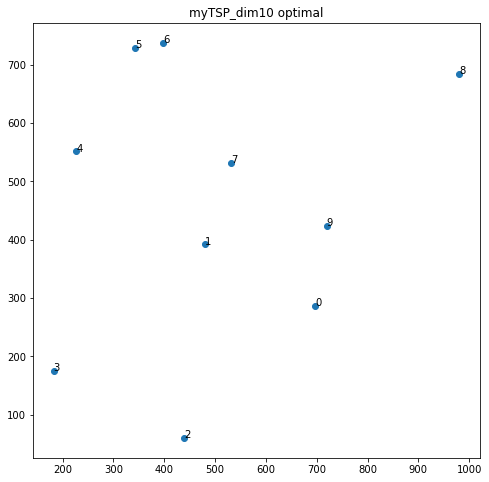

In [5]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [6]:
import time
from IPython import display
from matplotlib import pyplot as plt
%matplotlib notebook


def plot_tour(instance, tour, ant):
    """plot iterativerly the tour for that ant

    Args:
        instance (TSP_Instance_Creator): TSP problem
        tour (list): tour of the ant
        ant (int): ant number
    """
    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.title(f"Tour Ant # {ant}")
    plt.scatter(instance.points[:, 1], instance.points[:, 2])
    for t in range(len(tour)-1):
        xy1, xy2 = tour[t], tour[t+1]
        plt.plot([instance.points[xy1, 1], instance.points[xy2, 1]], [
                 instance.points[xy1, 2], instance.points[xy2, 2]], color="blue")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.1)


In [7]:
import numpy as np
import random
from solvers import local_search
from solvers.constructive_algorithms import nn
from solvers.two_opt_with_candidate import twoOpt_with_cl
from threading import Thread
from time import sleep
# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)


class ACS:
    m = 10
    beta = 2
    alpha = rho = 0.1
    cl = 15
    q0 = 0.98
    stop_after_secs = 0

    @staticmethod
    def take_candidates(j, dist_mat):
        """take candidate list

        Args:
            j (_type_): city name
            dist_mat (_type_): distance matrix

        Returns:
            _type_: np.array containing candidate list
        """
        return (np.argsort(dist_mat[j])[1:ACS.cl+1])

    @staticmethod
    def take_other_cities(j, dist_mat):
        """return cities not in the candidate list

        Args:
            j (_type_): city
            dist_mat (_type_): distance matrix

        Returns:
            _type_: list of cities close to city but not in candidate list
        """
        return (np.argsort(dist_mat[j])[ACS.cl+1:])

    def __init__(self, instance, q0=None, boost=False, timeStop=180):
        """Constructor

        Args:
            instance (_type_):problem to solve
            q0 (float, optional): . Defaults to None.
            boost (bool, optional): applying 2opt or not. Defaults to False.
            timeStop (int, optional): time after which stopping the algorithm. Defaults to 180.
        """
        self.boost = boost
        self.stop_after_secs = timeStop
        if (q0 != None):
            self.q0 = q0
        self.instance = instance
        self.n = instance.nPoints
        self.dist_mat = instance.dist_matrix
        _, self.L_nn = nn(instance.dist_matrix,
                          starting_node=np.random.choice(self.n))
        self.tau0 = 1./(float(self.n) * self.L_nn)

        # position collector for the Ants, TO BE UPDATED during the steps
        self.position = {i: None for i in range(ACS.m)}
        self.tour = {i: []
                     for i in range(ACS.m)}  # tour collector for the Ants
        #self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
        self.pheromone = {r: [self.tau0]*(self.n) for r in range(self.n)}
        self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(
            self.n)}  # per tutte le citta', prende le citta vicine
        #self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}
        self.eta = {r: [1./(self.dist_mat[r, s]+np.finfo(np.double).eps)
                        for s in range(self.n)] for r in range(self.n)}
        for k in self.eta:
            self.eta[k][k] = 0.
        self.tour_len = {i: 0. for i in range(ACS.m)}
        self.best_tour = []
        self.best_ant = 0
        self.best_tour_len = 10e10
        self.iterations = 1000000
        self.tour_len_global = []
        self.current_iteration = 0
        self.tour_len_over_iters = []
        self.count_exploitation = 0
        self.count_exploration = 0
        self.best_len = 0.
        self.best_tour_tmp = []

    def global_update(self):
        """Global pheromone updating
        """
        for k1, val1 in self.pheromone.items():

            for k2, val2 in self.pheromone.items():

                if (k1 == k2):
                    self.pheromone[k1][k2] = 0.
                else:
                    delta_tau = 0.
                    if (k1 in self.best_tour_tmp and k2 in self.best_tour_tmp):
                        delta_tau = 1./self.best_len

                    self.pheromone[k1][k2] = (
                        1. - self.alpha) * self.pheromone[k1][k2] + (self.alpha * delta_tau)
                    self.pheromone[k2][k1] = (
                        1. - self.alpha) * self.pheromone[k2][k1] + (self.alpha * delta_tau)

    def solve(self):
        """Solving ACS
        """
        threeMinutes = Thread(target=lambda: sleep(self.stop_after_secs))
        threeMinutes.start()
        for iteration in range(self.iterations):
            self.current_iteration = iteration

            self.loop()
            best_tour_ant = min(self.tour_len, key=self.tour_len.get)

            self.best_len = self.tour_len[best_tour_ant]

            self.best_tour_tmp = self.tour[best_tour_ant]
            if (self.best_len < self.best_tour_len):
                self.best_tour_len = self.best_len
                self.best_ant = best_tour_ant
                self.best_tour = self.best_tour_tmp

            if (self.boost):
                self.two_Opt_Improvement()
            self.global_update()
            self.tour_len_over_iters.append(self.best_len)
            self.tour_len_global.append(np.mean(list(self.tour_len.values())))

            if not threeMinutes.is_alive():
                break
            self.tour = {i: [] for i in range(ACS.m)}
            self.position = {i: None for i in range(self.m)}
            self.tour_len = {i: 0. for i in range(self.m)}

    def local_update(self, k):
        """local pheromone update

        Args:
            k (int): ant number
        """
        old_city = self.tour[k][-2]
        next_city = self.position[k]
        old_ph = self.pheromone[old_city][next_city]
        pheromon = ((1.-self.rho) * old_ph) + (self.rho * self.tau0)
        self.pheromone[old_city][next_city] = pheromon
        self.pheromone[next_city][old_city] = pheromon
        self.tour_len[k] += self.dist_mat[old_city, next_city]

    def loop(self):
        """each ant contructs its own tour
        """

        for node_idx in range(self.n):

            if (node_idx < self.n-1):

                for k in range(self.m):
                    if (self.position[k] == None):
                        self.position[k] = np.random.randint(
                            low=0, high=self.n-1)

                        self.tour[k].append(self.position[k])
                    q = np.random.random()

                    eta_beta = np.power(self.eta[self.position[k]], self.beta)

                    s_list = eta_beta * \
                        np.array(self.pheromone[self.position[k]])
                    s_list_cities = np.argsort(s_list)

                    if (q < self.q0):
                        self.count_exploitation += 1
                        #next_city = max(s_dict, key=s_dict.get)

                        for i in range(self.n):
                            if (s_list_cities[self.n-1-i] not in self.tour[k]):
                                next_city = s_list_cities[self.n-1-i]
                                break

                        self.position[k] = next_city
                        self.tour[k].append(next_city)

                    else:

                        possible_cities = []
                        new_s_list = []
                        for i in range(self.n):
                            if (i not in self.tour[k]):
                                new_s_list.append(s_list[i])

                                possible_cities.append(i)
                        sum_val = sum(new_s_list)
                        prob = new_s_list/sum_val

                        next_city = random.choices(
                            possible_cities, weights=prob, k=1)[0]

                        self.tour[k].append(next_city)
                        self.position[k] = next_city

                        self.count_exploration += 1

                    self.local_update(k)
            else:
                for k in range(self.m):
                    self.tour[k].append(self.tour[k][0])
                    self.tour_len[k] += self.dist_mat[self.tour[k]
                                                      [-2], self.tour[k][-1]]

    def two_Opt_Improvement(self):
        """two opt with CL
        """
        best_tour_new, best_tour_len_new = twoOpt_with_cl(
            self.best_tour_tmp, self.best_len, self.dist_mat, self.candidate_list)
        if (best_tour_len_new < self.best_len):
            self.best_len, self.best_tour_tmp = best_tour_len_new, best_tour_new
            if (self.best_len < self.best_tour_len):

                self.best_tour, self.best_tour_len = best_tour_new, best_tour_len_new


In [8]:
import pandas as pd
%matplotlib tk
seeds = [0, 42, 123]
q_s = [0.5, 0.98, 1.]
instances = ["eil76.tsp", "ch130.tsp", "d198.tsp"]
results = pd.DataFrame(columns=['q', 'boost', 'best integer len',
                       '# iterations', 'AVG integer len', 'STD ', 'Optimum', 'Rel error'])
counter = -1

results.to_csv("results_final_2.csv")
list_len_over_iter = []
list_of_len_global = []
for q in q_s[1:2]:

    if (q == 1.):
        q = q-(13./ic.nPoints)
    print(f"-------  Q0 = {q} ---------")
    for seed in seeds:
        print(f"-------  SEED = {seed} ---------")
        random.seed(seed)
        np.random.seed(seed)
        for boost in [True, False]:
            print(f"-------  Boost/2opt = {boost} ---------")

            results = {i: [] for i in instances}
            for instance in instances:

                print(f"-------  INSTANCE = {instance} ---------")
                ic = TSP_Instance_Creator("standard", instance)

                acs = ACS(ic, q, boost, 180)
                # print(acs.pheromone)
                # print(acs.candidate_list)
                acs.solve()
                results[instance].append(q)
                results[instance].append(boost)
                results[instance].append(acs.best_tour_len)
                results[instance].append(acs.current_iteration)
                results[instance].append(np.mean(acs.tour_len_global))
                results[instance].append(np.std(acs.tour_len_global))
                results[instance].append(ic.best_sol)
                results[instance].append(
                    ((acs.best_tour_len-ic.best_sol)*100.)/ic.best_sol)
                list_of_len_global.append(np.mean(acs.tour_len_global))
                list_len_over_iter.append(acs.tour_len_over_iters)

                print("best gap (%) = ",
                      ((acs.best_tour_len-ic.best_sol)*100.)/ic.best_sol)
                print("best cost = ", acs.best_tour_len)
                print("numbers of tours generated = ",
                      acs.current_iteration*acs.m)

            counter += 1
            results = pd.DataFrame(results).T
            results.columns = ['q', 'boost', 'best integer len',
                               '# iterations', 'AVG integer len', 'STD ', 'Optimum', 'Rel error']
            results.to_csv("results_final_2.csv", mode='a', header=False)
            print(results)


-------  Q0 = 0.98 ---------
-------  SEED = 0 ---------
-------  Boost/2opt = True ---------
-------  INSTANCE = eil76.tsp ---------


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
n_plots = len(list_len_over_iter)
num_rows = int(n_plots/3)
fig, axes = plt.subplots(nrows=num_rows, ncols=3 , figsize=(50, 80))
plt.grid()
row =-1
#print(axes.size)
cols = ['TSP Problem {}'.format(instances[col]) for col in range(3)]
rows = ['TSP {}'.format(row) for row in range(int(len(list_len_over_iter)/3))]
# ((np.array(list_len_over_iter[i])-ic.best_sol)*100.)/ic.best_sol
count =-3
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
boost_list=["2OPT\nMEAN=RED LINE", "NO 2 OPT\nMEAN=RED LINE"]

print(np.array(list_len_over_iter[0]).flatten())
#print("len of array of statistics", np.array(list_len_over_iter))
opt_solutions = [TSP_Instance_Creator("standard", instances[0]).best_sol, TSP_Instance_Creator("standard", instances[1]).best_sol, TSP_Instance_Creator("standard", instances[2]).best_sol]

for i in range(3):
    count_step = 3
    count = -3
    step_mean = int(300./(i+1))
    legend_index =0
    for ax, row in zip(axes[:,i], rows):
        print("row # ", row)
        ax.set_ylabel("GAP", rotation=0, size='large')
        ax.set_xlabel("Iterations", rotation=0, size='large')
        ax.grid()
        
        #ax.plot(list(range(len(list_len_over_iter[count+3]))), list_len_over_iter[count+3])
        #ax.plot([np.argmin(list_len_over_iter[count+3])], min(list_len_over_iter[count+3]), color='red')
        means =[]
        
        count_m = -step_mean
        lenght_x = []
        #print("len of the array", len(list_len_over_iter[i+count+count_step]))
        if(count+count_step+i<len(list_len_over_iter)):
            for j in np.array(list_len_over_iter[i+count+count_step])[::step_mean]:
                means.append((np.mean(np.array(list_len_over_iter[i+count+count_step]).flatten()[count_m+step_mean:count_m+2*step_mean])-opt_solutions[i])*100./opt_solutions[i])
                lenght_x.append(count_m+step_mean)
                count_m+=step_mean
            #print("len mean ", lenght_x, "values mean ", means)

            
            ax.plot(list(range(int(len(list_len_over_iter[i+count+count_step])))),( np.array(list_len_over_iter[i+count+count_step])-opt_solutions[i])*100./opt_solutions[i], label="GAP")
            try:
                ax.plot(lenght_x, means, color='red', label=boost_list[legend_index%2])
                ax.legend(loc="upper right", shadow=True)
                legend_index+=1
                
            except:
                print("out of range")
            
            count+=count_step
            
    
    #plt.plot([np.argmax(acs.tour_len_over_iters), np.argmin(acs.tour_len_over_iters)], [max(acs.tour_len_over_iters), min(acs.tour_len_over_iters)], color="blue")
plt.show()

## ANT TOUR (REALTIME)
I will show how the best ant will build its own tour on the TSP eil76

In [ ]:

instance = instances[0]
print(instance)
ic = TSP_Instance_Creator("standard", instance)
np.random.seed(43)
acs = ACS(ic, 0.98, boost=True, timeStop=180)
#print(acs.tour_len_over_iters)
#print(acs.eta)
acs.solve()


In [ ]:
%matplotlib inline
print(np.argsort(acs.tour_len_over_iters[:]))
print(type(acs.tour_len_over_iters[0]))
total= float(acs.count_exploitation)+float(acs.count_exploration)
print("exploitations= ", float(acs.count_exploitation)*100/total, " % ")
print("solution NN: ", acs.L_nn, " mine: ", acs.best_tour_len)
fig= plt.figure(figsize=(12, 6))
plt.grid()
plt.ylabel("GAP %")
plt.xlabel("Iterations")
plt.plot(list(range(int(acs.current_iteration)+1)), ((np.array(acs.tour_len_over_iters[::])-ic.best_sol)*100.)/ic.best_sol, color="red")
#plt.plot([np.argmax(acs.tour_len_over_iters), np.argmin(acs.tour_len_over_iters)], [max(acs.tour_len_over_iters), min(acs.tour_len_over_iters)], color="blue")
plt.show()

In [ ]:
%matplotlib inline
plot_tour(acs.instance, acs.best_tour,acs.best_ant)


Comparing with NN tour solution

In [ ]:
%matplotlib inline
t, L_nn = nn(acs.instance.dist_matrix,
                          starting_node=np.random.choice(acs.n))
t.append(t[0])
plot_tour(acs.instance, t,acs.best_ant)

# REPORT

Overall, I got good results with the ANT colony system as shown in the plots above. Indeed, if one looks at the results called "results_final". I run different combinations: 3 different q0, 2 different variants, 3 different seeds, and 3 different instances. \
For instance, for problem eil76 I got the minimum value equal to 2.97. 
For plots I only considered just ANTS with q0=0.98. 

In [ ]:
data = pd.read_csv("CSV/results_final.csv")
data = data.rename(columns={"Unnamed: 0": "Instance"})

print("Min gap % for instance eil76.tsp:\n")
print(data.loc[data["Instance"] =="eil76.tsp"].min())
print("\nMin gap % for instance ch130.tsp:\n")
print(data.loc[data["Instance"] =="ch130.tsp"].min())
print("\nMin gap % for instance d198.tsp:\n")
print(data.loc[data["Instance"] =="d198.tsp"].min())
array_min_gap = [data.loc[data["Instance"] =="eil76.tsp"]["Rel error"].min(), data.loc[data["Instance"] =="ch130.tsp"]["Rel error"].min(), data.loc[data["Instance"] =="d198.tsp"]["Rel error"].min()]
plt.figure(figsize=(12,8))
plt.bar(instances, array_min_gap)
plt.xlabel("INSTANCES")
plt.ylabel("GAP %")
plt.grid()
plt.title("BEST RESULTS")
plt.show()